# Identify fraud in Enron corpus

## by Aarthy  Vallur

### The Enron corpus
The Enron corpus is a large database of over 600,000 emails from and to 156 employees of the Enron Corporation. The dtabase was collected over a 2 week period in May, 2002 by a contractor hired by the FERC which was investigating the causes and frauds in the company's sudden bankruptcy in Dec, 2001. The corpus is unique in that it is one of the few publicly available email data sets, as similar datasets are usually rendered unusable due to stringent privacy laws and controls.
The Enron corpus was a window into the widespread financial and and trading scandals that plagued Enron Corporation prior to its collapse which bankrupted thousands of share holders in 2001. The entire scandal and the chief executives implicated in the scandal are detailed at [Enron Corporation scandal](https://en.wikipedia.org/wiki/Enron). The term "person of interest" or "poi" (as depicted in the corpus) was used to tentatively identify those employees with a high chance of playing an active part in the frauds that preceeded Enron's collapse. Many features, including their financial, stock and email records were used to identify those that could be considered "poi"s. 

### The dataset
The dataset provided of the Enron employees, includes financial, stock and email records of 146 employees at Enron. Our task is to employ data cleaning and machine learning techniques to identify pois given this information. The goal is to come up with an algorithm with precision and recall > 0.3 that can reasonably identify those employees that have a high chance of being pois. Key features of the dataset are as follows

In [1]:
## Loading the packages and codes necessary
%matplotlib inline
import matplotlib.pyplot
import sys
import pickle
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from feature_format import featureFormat, targetFeatureSplit
from time import time
import numpy as np
np.random.seed(42)
import pandas
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing 
import tester

In [2]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
## Exploring data 
print "There are", len(data_dict), "entries in the enron email file"
## Total number of features 
all_features =  data_dict['METTS MARK'].keys()
print "There are", len(data_dict['METTS MARK']), "features for each person in the enron email datafile and they are"
print all_features


There are 146 entries in the enron email file
There are 21 features for each person in the enron email datafile and they are
['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


There are a total of 146 individuals in the given dataset with each having information grouped under 21 features. Of these,'salary', 'deferral_payments', 'total_payments', expenses', 'long_term_incentive', 'loan_advances', 'director_fees' and 'deferred_income' refer to financial trasactions. While, 'exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred' and 'total_stock_value'refer to stock trasactions. Email transactions are represented by 'to_messages', 'shared_receipt_with_poi', 'from_messages', 'from_this_person_to_poi' and 'from_poi_to_this_person'. Descriptive feature with no bearing on poi status are 'email_address' while 'other' is ill- defined. 'poi' refers to a pre- existing label which will be further explored in this project.

In [3]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi". 
### making feature list with poi as the label. Chose features that are likely to matter for pois, including financial and email related features. 
### "email address" was not chosen since it is descriptive and "other" was not chosen as it is ill- defined
features_list = ['poi', 'salary', 'total_payments', 'exercised_stock_options', 'bonus', 'total_stock_value', 'long_term_incentive', 'shared_receipt_with_poi', 'from_this_person_to_poi', 'from_poi_to_this_person', 'restricted_stock', 'restricted_stock_deferred', 'deferred_income', 'director_fees', 'expenses']
## There are financial and email related features of which total_payments and total_stock_value are aggregate features

In [4]:
## Exploring the names in data_dict with respect to poi
count_poi = 0
poi_list = []
for user in data_dict:
    if data_dict[user]["poi"] == True:
        count_poi+=1
        poi_list.append(user)
print "There are", count_poi, "pois in the datafile and they are", poi_list
## Looking for persons with NaNs in salary, bonus, total payments and exercised stock options as these are important features
for user in data_dict:
        if data_dict[user]["salary"] == 'NaN' and data_dict[user]["bonus"] == 'NaN' and data_dict[user]["total_payments"] == 'NaN' and data_dict[user]["exercised_stock_options"] == 'NaN' and data_dict[user]["total_stock_value"]:
            print user, "have NaN for salary, bonus, total payments and exercised stock options"
## 6 names had a bunch of NaN values for the major feaures chosen. Exploring all six for all features           
print "Features and values for Chan Ronnie are", data_dict["CHAN RONNIE"]   
print "Features and values for Kenneth Cline are", data_dict["CLINE KENNETH W"]           
print "Features and values for William Powers are", data_dict["POWERS WILLIAM"]           
print "Features and values for Jim Piro are", data_dict["PIRO JIM"]           
print "Features and values for Eugene Lockhart are", data_dict["LOCKHART EUGENE E"]           
print "Features and values for Roderick Hayslett are", data_dict["HAYSLETT RODERICK J"]
## Apart from Eugene Lockhart, all others have large values for restricted stocks, director's fees and deferred payments. Eugene Lockhart has NaN for all feaures and thus qualifies as an outlier.

There are 18 pois in the datafile and they are ['HANNON KEVIN P', 'COLWELL WESLEY', 'RIEKER PAULA H', 'KOPPER MICHAEL J', 'SHELBY REX', 'DELAINEY DAVID W', 'LAY KENNETH L', 'BOWEN JR RAYMOND M', 'BELDEN TIMOTHY N', 'FASTOW ANDREW S', 'CALGER CHRISTOPHER F', 'RICE KENNETH D', 'SKILLING JEFFREY K', 'YEAGER F SCOTT', 'HIRKO JOSEPH', 'KOENIG MARK E', 'CAUSEY RICHARD A', 'GLISAN JR BEN F']
CHAN RONNIE have NaN for salary, bonus, total payments and exercised stock options
CLINE KENNETH W have NaN for salary, bonus, total payments and exercised stock options
POWERS WILLIAM have NaN for salary, bonus, total payments and exercised stock options
PIRO JIM have NaN for salary, bonus, total payments and exercised stock options
LOCKHART EUGENE E have NaN for salary, bonus, total payments and exercised stock options
HAYSLETT RODERICK J have NaN for salary, bonus, total payments and exercised stock options
Features and values for Chan Ronnie are {'salary': 'NaN', 'to_messages': 'NaN', 'deferral_paymen

There were 18 individuals identified as pois. For 6 individuals, the aggregate functions had a value of "NaN", making them possible outliers with no useful information. Upon closer examination, except for one, the other 5 did have meaningful enties for other fiancial, email and stock features but for Eugene Lockhart, all values were NaN, which makes him a clear candidate for removal.

In [5]:
## More analysis of bivariate relationships in data_dict, using salary and bonus
## Analysing for users with high salary and bonus
high_salary_bonus_list = []
for user in data_dict:
    if data_dict[user]["salary"] != 'NaN' and data_dict[user]["salary"] >= 1000000 and data_dict[user]["bonus"] != 'NaN' and data_dict[user]["bonus"] >= 5000000:
        high_salary_bonus_list.append(user)
print "Top 3 persons based on salary and bonus are:", high_salary_bonus_list
## Only 3 users have a salary> 1000000 and bonus > 5000000. Of these 'Total" does not seem to be a real person and is possibly an outlier.
## It could be a data entry error. If so, the values for 'Total" will be orders variant from the 2 next highest users. Verifying this
print "Salary and bonus for Total are", data_dict["TOTAL"]["salary"], "and", data_dict["TOTAL"]["bonus"]
print "Salary and bonus for Kenneth Lay are", data_dict["LAY KENNETH L"]["salary"], "and", data_dict["LAY KENNETH L"]["bonus"]
print "Salary and bonus for Jeffrey Skilling are", data_dict["SKILLING JEFFREY K"]["salary"], "and", data_dict["SKILLING JEFFREY K"]["bonus"]
## Clearly, Total seems to be a calculation and data processing error as it is many magnitudes higher than the next 2 hihest values. 
## More analysis of bivariate relationships in data_dict, this time using the aggregate features, total payments  and total stock value
## Analysing for users with high total payments and stock value
high_payment_stock_list = []
for user in data_dict:
    if data_dict[user]["total_payments"] != 'NaN' and data_dict[user]["total_payments"] >= 2500000 and data_dict[user]["total_stock_value"] != 'NaN' and data_dict[user]["total_stock_value"] >= 5000000:
        high_payment_stock_list.append(user)
print"There are", len(high_payment_stock_list), "persons who received total payments > 2500000 and total stock options > 5000000. They are", high_payment_stock_list
## The names on this list look real. No outliers here.
## Now checking how high salary, bonus and total stock options correlate with poi status
high_salary_list = []
high_bonus_list = []
high_total_stock_list = []
for user in data_dict:
    if data_dict[user]["salary"] != 'NaN' and data_dict[user]["salary"] >= 500000:
        high_salary_list.append((user, int(data_dict[user]["salary"])))       
print "People with the highest salary are", high_salary_list
high_salary_list_poi = []
for user in high_salary_list:
    if data_dict[user[0]]["poi"] == True:
        high_salary_list_poi. append(user[0])
print "These", len(high_salary_list_poi),"people making a salary >500000 are also pois", high_salary_list_poi
## 2 of the people with highest salary are also pois.
## Repeating the same for bonus and total stock options
for user in data_dict:
    if data_dict[user]["bonus"] != 'NaN' and data_dict[user]["bonus"] >= 3000000:
        high_bonus_list.append((user, int(data_dict[user]["bonus"])))       
print "People with the highest bonus are", high_bonus_list
high_bonus_list_poi = []
for user in high_bonus_list:
    if data_dict[user[0]]["poi"] == True:
        high_bonus_list_poi. append(user[0])
print "These", len(high_bonus_list_poi), "people making a bonus >3000000 are also pois", high_bonus_list_poi 
for user in data_dict:
    if data_dict[user]["total_stock_value"] != 'NaN' and data_dict[user]["total_stock_value"] >= 5000000:
        high_total_stock_list.append((user, int(data_dict[user]["total_stock_value"])))       
print "People with the highest total stock value are", high_total_stock_list
high_total_stock_list_poi = []
for user in high_total_stock_list:
    if data_dict[user[0]]["poi"] == True:
        high_total_stock_list_poi. append(user[0])
print "These", len(high_total_stock_list_poi), "people holding a total stock value >5000000 are also pois", high_total_stock_list_poi


Top 3 persons based on salary and bonus are: ['LAY KENNETH L', 'SKILLING JEFFREY K', 'TOTAL']
Salary and bonus for Total are 26704229 and 97343619
Salary and bonus for Kenneth Lay are 1072321 and 7000000
Salary and bonus for Jeffrey Skilling are 1111258 and 5600000
There are 9 persons who received total payments > 2500000 and total stock options > 5000000. They are ['BAXTER JOHN C', 'HORTON STANLEY C', 'LAVORATO JOHN J', 'WHALLEY LAWRENCE G', 'LAY KENNETH L', 'SKILLING JEFFREY K', 'TOTAL', 'FREVERT MARK A', 'PAI LOU L']
People with the highest salary are [('WHALLEY LAWRENCE G', 510364), ('LAY KENNETH L', 1072321), ('SKILLING JEFFREY K', 1111258), ('PICKERING MARK R', 655037), ('TOTAL', 26704229), ('FREVERT MARK A', 1060932)]
These 2 people making a salary >500000 are also pois ['LAY KENNETH L', 'SKILLING JEFFREY K']
People with the highest bonus are [('KITCHEN LOUISE', 3100000), ('LAVORATO JOHN J', 8000000), ('WHALLEY LAWRENCE G', 3000000), ('DELAINEY DAVID W', 3000000), ('LAY KENNETH 

The above analyses show the overlap between having high salary, bonus and total stock value and being pois. These are features that will be very useful in predicting pois.

### Outlier removal
As identified in the data set analysis above, 3 clear outliers can be removed to clean up the data set. They are
1. Travel Agency in the park- Clearly not an emploee
2. Eugene Lockhart- All features are NaN
3. Total- Seems to be a spreadsheet error
These were removed from the data dictionary to create an outlier- free data for further analysis

In [6]:
### Outlier removal
data_dict.pop("THE TRAVEL AGENCY IN THE PARK")
data_dict.pop("LOCKHART EUGENE E")
data_dict.pop("TOTAL", 0)
print "There are", len(data_dict), "users in the enron datafile after removing the outliers"
## Cleaned data is ready for storing data-dict as my_dataset as required for grader

There are 143 users in the enron datafile after removing the outliers


### Creation of new feature
Given that the financial and stock- based features have an aggregated feature whch seems to be very meaningful, I thought auch an aggregate feature for the emails will be useful as a new featrure. So, I created an aggregate feature summing the fraction of emails a person received from a poi or sent to a poi. The rationale was that, any email inyteractions with a poi could mean that the person is also a poi. This new feature, "fraction_to_from_poi", aggregates all email exchanges between the user and the pois already indicated, as a fraction of their total email exchanges.

In [7]:
### Task 3: Create new feature(s)
## making a new feature which combines fraction of emails from and to poi and the user
## function to derive fraction of messages from or to poi over all messages
def email_fraction(email_poi, email_all):
    fraction_of_messages = 0.
    if email_poi == 'NaN' or email_poi == 'NaNNaN':
        email_poi == 0
    if email_all == 'NaN' or email_all == 'NaNNaN':
        return fraction_of_messages
    fraction_of_messages = float(email_poi)/float(email_all)
    return fraction_of_messages
## computing fraction of emails from and to poi
## creating a new key:value pair to denote the total fraction of emails from and to pois
for user in data_dict:   
    all_emails = (data_dict[user]["to_messages"]) + (data_dict[user]["from_messages"])
    all_poi = (data_dict[user]["from_poi_to_this_person"]) + (data_dict[user]["from_this_person_to_poi"])
    fraction_to_from_poi = email_fraction(all_poi, all_emails)
    data_dict[user]["fraction_to_from_poi"] = fraction_to_from_poi
## checking whether the addition worked. 
print "The fraction of emails for Jim Piro to and from pois is", data_dict["PIRO JIM"]["fraction_to_from_poi"]
print "The fraction of emails for Ken Lay to and from pois is", data_dict["LAY KENNETH L"]["fraction_to_from_poi"]

The fraction of emails for Jim Piro to and from pois is 0.0135135135135
The fraction of emails for Ken Lay to and from pois is 0.0322580645161


In [8]:
## It worked!! Now is this even significant? Checking how many users had a positive interction with pois
poi_email_fraction_count = 0
for user in data_dict:
    if data_dict[user]["fraction_to_from_poi"] != 0:
        poi_email_fraction_count += 1
print "There are", poi_email_fraction_count, "users with a positive fraction of emails to and from pois"

There are 77 users with a positive fraction of emails to and from pois


It is clear from the above output that more than half the users had some email exchange with pois. I am assuming that this interacton will be more impactful as a feature for poi identification when aggregated as above.

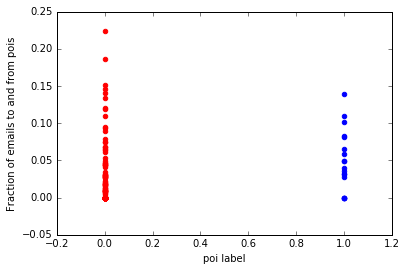

In [9]:
## Correlation with pois using a simple scatter plot to see if the the fraction_to_from_poi is distinct for pois and non-pois
for user in data_dict:
    poi = data_dict[user]["poi"]
    fraction_to_from_poi = data_dict[user]["fraction_to_from_poi"]
    if poi == True:
        matplotlib.pyplot.scatter(poi, fraction_to_from_poi, color = "b")
    else:
        matplotlib.pyplot.scatter(poi, fraction_to_from_poi, color = "r")
matplotlib.pyplot.xlabel("poi label")
matplotlib.pyplot.ylabel("Fraction of emails to and from pois")
matplotlib.pyplot.show()


The scatter plot above shows that for most of the pois, the fraction is positive. But this is not very useful to understand whether the distribution is really different for pois and non- pois. Will see if this feature is significant using feature selection algorithms.

In [10]:
## Adding the new feature to features_list to see if that improves the decision tree
features_list.append('fraction_to_from_poi')
print features_list

['poi', 'salary', 'total_payments', 'exercised_stock_options', 'bonus', 'total_stock_value', 'long_term_incentive', 'shared_receipt_with_poi', 'from_this_person_to_poi', 'from_poi_to_this_person', 'restricted_stock', 'restricted_stock_deferred', 'deferred_income', 'director_fees', 'expenses', 'fraction_to_from_poi']


New feature has been added to feature list, which is now ready to be incorporated into algorithms

In [11]:
### Store to my_dataset for easy export below. The cleaned data dictionary is stored as my_dataset
my_dataset = data_dict

### Data extraction and preparation for cross validation
Data was extracted with 'poi' as label and the rest as features. Used the StratifiedShuffleSplit recommended for this data set with 1000 fold random splitting iterations, as tyhe cross validation technique. Cross validation is the emans by which the classifier is thoroughly verified for application across the dataset and is a means to avoid both over and underfitting data. Though I am more used to splitting the data into discrete trainign and testing (usually a 70-30 split) points, I tried this as the cross validator. Later after algorithm tuning, the train- test- split was also tried.

In [12]:
### Extract features and labels from dataset for local testing
### Extract features and labels from my_dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)   
folds = 1000
cv = StratifiedShuffleSplit(labels, folds, random_state= 42)  

### Classifiers
I set up 3 classifiers- A simple Gaussian Naive Bayes, a KMeans to look at clustering effects and a Decision tree to enable a choice for further tuning and boosting. In all three, the features from the above created list were 
scaled using the MinMaxScaler for standardising as well as making them robust in the algorithm.

### Evaluation
Evaluation is the process of objectively assessing the performance of the classifier in predicting the outcome. Evaluation can be achieved by comparing many metrics. As evaluation metrics, accuracy, precision, recall and F1 scores were chosen, though the latter 3 were given more consideration. Due to the abundance of non- pois in the dataset, it is possible that, even with low precision and recall, the accuracy is still high. This was actually noticed in many trial runs of classifiers. 

In [13]:
### Task 4: Try a varity of classifiers
## Setting up 3 classifiers with feature scaling
## Gaussian NB
print "Gaussian NB classifier output:"
NB_clf = Pipeline(steps =[('scaling', preprocessing.MinMaxScaler()), ('classifier', GaussianNB())])
t0 = time()
tester.test_classifier(NB_clf,my_dataset,features_list)
print "Gaussian NB run time:", round(time ()- t0, 3),"s"

Gaussian NB classifier output:
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', GaussianNB())])
	Accuracy: 0.32467	Precision: 0.15463	Recall: 0.91000	F1: 0.26434	F2: 0.46029
	Total predictions: 15000	True positives: 1820	False positives: 9950	False negatives:  180	True negatives: 3050

Gaussian NB run time: 1.597 s


With just the selected features and feature scaling, Gaussian NB gave low precision but high recalland moderate F1 score. Accuracy was also low, though I do not want to consider it a key evaluation metric.

In [14]:
## KMeans
print "KMeans classifier output:"
KM_clf = Pipeline(steps =[('scaling', preprocessing.MinMaxScaler()), ('classifier', KMeans(n_clusters = 2))])
t0 = time()
tester.test_classifier(KM_clf,my_dataset,features_list)
print "KMeans run time:", round(time ()- t0, 3),"s"

KMeans classifier output:
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0))])
	Accuracy: 0.51607	Precision: 0.13994	Recall: 0.51100	F1: 0.21971	F2: 0.33392
	Total predictions: 15000	True positives: 1022	False positives: 6281	False negatives:  978	True negatives: 6719

KMeans run time: 17.278 s


Kmeans with 2 clusters had a similar output as Gaussian NB, high recall but low precision but takes much longer to run

In [15]:
## Decision tree
print "Decision Tree classifier output:"
DT_clf = Pipeline(steps =[('scaling', preprocessing.MinMaxScaler()), ('classifier', DecisionTreeClassifier())])
t0 = time()
tester.test_classifier(DT_clf,my_dataset,features_list)
print "Decision Tree run time:", round(time ()- t0, 3),"s"


Decision Tree classifier output:
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.80520	Precision: 0.27380	Recall: 0.27900	F1: 0.27637	F2: 0.27794
	Total predictions: 15000	True positives:  558	False positives: 1480	False negatives: 1442	True negatives: 11520

Decision Tree run time: 1.751 s


Decision tree had higher accuracy than KMeans and Gaussian NB and had better precision and recall balance, with both tending towards 0.3 but not quite 0.3.

In [16]:
## Getting feature rankings for all except label to see how they stack in terms of importance in the Decision Tree algorithm
importances = DT_clf.steps[-1][1].feature_importances_
indices = np.argsort(importances)[::-1]
print "Feature Ranking"
for i in range(10):
    print "{} {}: {}". format(i+1, features_list[1:][indices[i]], importances[indices[i]])

Feature Ranking
1 expenses: 0.339068452381
2 exercised_stock_options: 0.216469387755
3 deferred_income: 0.107142857143
4 fraction_to_from_poi: 0.0810267857143
5 restricted_stock: 0.0666666666667
6 from_this_person_to_poi: 0.0574829931973
7 bonus: 0.0535714285714
8 long_term_incentive: 0.0507936507937
9 total_stock_value: 0.0277777777778
10 director_fees: 0.0


The new feature created, fraction_to_from_poi is 4th in the importances, it must be of some significance.  Proceeded to feature selection using KBest features. SelectKBest is a univariated fearure selection algorithm lets us select to top ranking features based on scores. I chose the Top 10 KBest features, hoping to streamline feature selection and identify the most impactful features.

In [17]:
## Will use k-best algorithm to select features
from sklearn.feature_selection import SelectKBest
select = SelectKBest(k = 10)
## Removinf poi as a feature for k best
features_list_k = features_list[1:]
kbest_features = select.fit(features, labels)
kbest_scores = kbest_features.scores_
kbest_feature_score = zip(features_list_k[1:], kbest_scores)
## converting to array for sorting by score
selected_features = pandas.DataFrame(kbest_feature_score, columns =['Feature', 'Score'])
selected_features = selected_features.sort_values(by ='Score', ascending = False)
print "The top KBest features selected from features_list are"
print selected_features.to_string(index = False)

The top KBest features selected from features_list are
                   Feature      Score
                     bonus  24.815080
       long_term_incentive  24.182899
         total_stock_value  20.792252
            total_payments  18.289684
             director_fees  11.458477
   shared_receipt_with_poi   9.922186
 restricted_stock_deferred   9.212811
   exercised_stock_options   8.772778
   from_this_person_to_poi   8.589421
      fraction_to_from_poi   6.094173
          restricted_stock   5.243450
   from_poi_to_this_person   2.382612
                  expenses   2.126328
           deferred_income   0.065500


The KBest features are remarkably different from the features ranked from the Decision tree. But, the new feature created, fraction_to_from_poi, is still part of the top 10 features, ranked at 10. The Decision Tree was re- run with KBest fetaures, using the pipeline with feature scaling and the tester's cross validation.

In [18]:
## Rerunning Decision tree with KBest features after updating the features_list
features_list = ['poi', 'bonus', 'long_term_incentive', 'total_stock_value', 'total_payments', 'director_fees', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'exercised_stock_options', 'from_this_person_to_poi', 'fraction_to_from_poi', 'restricted_stock', 'from_poi_to_this_person', 'expenses', 'deferred_income']
print "Decision Tree classifier with KBest features output:"
DT_K_clf = Pipeline(steps =[('scaling', preprocessing.MinMaxScaler()), ('classifier', DecisionTreeClassifier(random_state = None))])
t0 = time()
tester.test_classifier(DT_K_clf,my_dataset,features_list)
print "Decision Tree run time:", round(time ()- t0, 3),"s"


Decision Tree classifier with KBest features output:
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.80567	Precision: 0.27363	Recall: 0.27650	F1: 0.27506	F2: 0.27592
	Total predictions: 15000	True positives:  553	False positives: 1468	False negatives: 1447	True negatives: 11532

Decision Tree run time: 1.713 s


KBest features coupled with feature scaling do not alter the outcome of the Decision Tree algorithm. The algorithms need tuning in terms of classifier parameters. Chose to tune Gaussian NB and Decision Tree , dimensionality reduction, GridSearch CV and boosting.

### Tuning the classifier
Tuning the classifier is the process of choosing the parameters that lead to the best performance of the classifier. Tuning can be done in many ways. I chose to reduce dimensions using PCA and use GridSerach CV which lets us mix and match parameters in a deliberate matrix, thereby arriving at the best parameters for a given classifier.
Gaussian NB cannot be really tuned by altering parameters, only feature selection and PCA were employed to tune it. On the other hand, Decision Tree was tuned with GridSearchCV, with several choices of core performance parameters. The best parameters were then chosen to be boosted by AdaBoost which was in turn tuned by GridSearchCV. For all pipelines, features were scaled and F1 scores were used as the evaluation metric to assess the performce of the classifier, since F1 score is the weighted average of precision and recall. Cross validation was achieved by use of the tester's data split.

In [19]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

## Tuning Gaussian NB with PCA to reduce dimensions. Grid Search CV has no parameters to set for NB
print "Gaussian NB classifier with PCA output:"
NB_PCA_clf = Pipeline(steps =[('scaling', preprocessing.MinMaxScaler()),('pca', PCA(copy = True, n_components = 0.95, whiten = False)), ('gaussian', GaussianNB())])
t0 = time()
tester.test_classifier(NB_PCA_clf,my_dataset,features_list)
print "Gaussian NB with PCA run time:", round(time ()- t0, 3),"s"

Gaussian NB classifier with PCA output:
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, n_components=0.95, whiten=False)), ('gaussian', GaussianNB())])
	Accuracy: 0.82153	Precision: 0.34855	Recall: 0.38950	F1: 0.36789	F2: 0.38056
	Total predictions: 15000	True positives:  779	False positives: 1456	False negatives: 1221	True negatives: 11544

Gaussian NB with PCA run time: 2.1 s


PCA drastically improves the performance of the Gaussian NB algorithm!!

In [20]:
## Using PCA to reduce dimensions for decision tree
print "Decision Tree classifier with PCA output:"
DT_PCA_clf = Pipeline(steps =[('scaling', preprocessing.MinMaxScaler()), ('pca', PCA(copy = True, n_components = 0.95, whiten = False)), ('classifier', DecisionTreeClassifier(random_state = None))])
t0 = time()
tester.test_classifier(DT_PCA_clf,my_dataset,features_list)
print "Decision Tree run time:", round(time ()- t0, 3),"s"

Decision Tree classifier with PCA output:
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, n_components=0.95, whiten=False)), ('classifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.79153	Precision: 0.21439	Recall: 0.21150	F1: 0.21294	F2: 0.21207
	Total predictions: 15000	True positives:  423	False positives: 1550	False negatives: 1577	True negatives: 11450

Decision Tree run time: 2.232 s


The performance of the Decision Tree algorithm falls with PCA. Will proceed to tune this algorithm to find the best parameters.

In [22]:
## Tuning Decision Tree with Grid Search CV
param_grid = [{'classifier__min_samples_split': [2, 4],
          'classifier__max_depth': [None, 3, 8],
          'classifier__max_features': [None, 'auto', 'log2'],
          'classifier__criterion': ['gini', 'entropy'],
          'classifier__splitter': ['best', 'random'],
          'classifier__min_weight_fraction_leaf': [0, 0.1],
          'classifier__class_weight': [{1: 1, 0: 0.5}, {1: 0.8, 0: 0.3}]
    }]
DT_grid_clf = Pipeline(steps =[('scaling', preprocessing.MinMaxScaler()), ('classifier', DecisionTreeClassifier(random_state = None))])
DT_grid = GridSearchCV(DT_grid_clf, param_grid, cv=cv, scoring = 'f1')
DT_grid.fit(features, labels)
print "Decision Tree tuning by GridSearchCV"
print "Best parameters:", DT_grid.best_params_, "and Best score:", DT_grid.best_score_


Decision Tree tuning by GridSearchCV
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_split': 4, 'classifier__class_weight': {0: 0.5, 1: 1}, 'classifier__splitter': 'best', 'classifier__min_weight_fraction_leaf': 0.1, 'classifier__max_depth': 3, 'classifier__criterion': 'gini'} and Best score: 0.337226334776


Now that the best combination of parameters for the Decision Tree algorithm have been found, will re- run the algorithm using the tester with the best parameters.

In [23]:
## Running decision tree algorithm with best parameters
DT_best_clf = DT_K_clf.set_params(**DT_grid.best_params_)
t0 = time()
tester.test_classifier(DT_best_clf,my_dataset,features_list)
print "Decision Tree run time:", round(time ()- t0, 3),"s"

Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', DecisionTreeClassifier(class_weight={0: 0.5, 1: 1}, criterion='gini',
            max_depth=3, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.1, presort=False, random_state=None,
            splitter='best'))])
	Accuracy: 0.82960	Precision: 0.36479	Recall: 0.37500	F1: 0.36982	F2: 0.37291
	Total predictions: 15000	True positives:  750	False positives: 1306	False negatives: 1250	True negatives: 11694

Decision Tree run time: 1.804 s


The metrics are much better now, but may be improved even more by boosting. Adaboost has the capacity to iteratively boost the contribution of the weker features, which will give improved metrics, if it works. Using the Decision Tree with best parameters as a base estimator, will cinfigure the best parameters, such as number of estimators and the learning rate for AdaBoost using GridSearchCV.

In [24]:
###  Will boost this with Adaboost to see if metrics are better
DT_best_params = DT_best_clf.steps[-1][1].get_params()

In [25]:
## Using these parameters, do a grid serachCV for best Adaboost params
AB_params = [{'classifier__base_estimator': [DecisionTreeClassifier(**DT_best_params)],
'classifier__n_estimators': [5, 10, 50, 70],
'classifier__learning_rate': [0.5, 1, 2]
}]
AB_grid_clf = Pipeline(steps = [('scaling', preprocessing.MinMaxScaler()), ('classifier', AdaBoostClassifier(random_state = None))])
AB_grid = GridSearchCV(AB_grid_clf, AB_params, cv = cv, scoring = 'f1')
AB_grid.fit(features, labels)
print "AdaBoost tuning of Decision Tree by GridSearchCV"
print "Best parameters:", AB_grid.best_params_, "and Best score:", AB_grid.best_score_

AdaBoost tuning of Decision Tree by GridSearchCV
Best parameters: {'classifier__learning_rate': 2, 'classifier__base_estimator': DecisionTreeClassifier(class_weight={0: 0.5, 1: 1}, criterion='gini',
            max_depth=3, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.1, presort=False, random_state=None,
            splitter='best'), 'classifier__n_estimators': 5} and Best score: 0.22113015873


In [26]:
## Running decision tree algorithm with best features and boosting
AB_best_clf = AB_grid_clf.set_params(**AB_grid.best_params_)
t0 = time()
tester.test_classifier(AB_best_clf,my_dataset,features_list)
print "AdaBoost run time:", round(time ()- t0, 3),"s"

Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight={0: 0.5, 1: 1}, criterion='gini',
            max_depth=3, max_features=None, max_leaf_nodes=None,
            min_sa...=None,
            splitter='best'),
          learning_rate=2, n_estimators=5, random_state=None))])
	Accuracy: 0.80180	Precision: 0.24961	Recall: 0.24250	F1: 0.24601	F2: 0.24389
	Total predictions: 15000	True positives:  485	False positives: 1458	False negatives: 1515	True negatives: 11542

AdaBoost run time: 20.822 s


Adaboosting did not add anything to the Decision tree. It is possible that other tuning mechanisms may yield better metrics as well as other base estimators. 

### Best Classifier
At this point, I will choose the GridSearch CV tuned Decision Tree as my best classifier based on its precision, recall and F1 scores, which were similar to the next best PCA- transformed Gaussian NB classifier. Summarising both,

Performance of Decision Tree tuned by Grid Search 
Accuracy: 0.82960	Precision: 0.36479	Recall: 0.37500	 F1: 0.36982
Performance of Gaussian NB transformed by PCA
Accuracy: 0.82153	Precision: 0.34855	Recall: 0.38950	 F1: 0.36789

For cross validation, I tried train_test_split to withhold 30% of the data for testing and used the rest for training. The tester uses StratifiedShufflesplit (folds=1000) for cross validation. Both were similar, though the tester's cross validation yielded slightly better metrics. 

In this project, evaluation was done by comparing precision, recall and F1 scores as standard metrics. Accuracy is a measure of correct poi identifications, which given the high non-poi : poi ratio, will be high and hence is not a very meaningful metric. Precision, which is the measure of true positives identified among all positives, gives a measure of identification of ture pois. Here, it means that 36.5% of pois identified are true pois. Whereas Recall is a measure of false negatives identified. Here, a recall of 0.375, means there are some false negatives, who should be identified as true positives by the algorithm. The F1 score is  mid- range  reflecting both these metrics. To summarise, some true pois will not be identified in this algorithm. But the pois identified can be reliably considered true pois and an investigation of their records will be useful in leading to the roots of the fraud. But ethical use of data and the outcome of the learning process ought to be ensured too.

### Conclusion
My take on the dataset and what I learned by applying machine learning techniques in identifying pois is that
1. A dataset such as this, with a bunch of distinct aspects- financial, stock and email exchange, has unique qualities that lend it to multiple channels of investigation. 
2. But, given the extensive nature of the data, the information is still not complete (a high incidence of NaNs) or realated enough to be applicable across the board for identifying pois. Except for some individuals, who are clearly pois, others are difficult to predict  following the same trend. It is this grey area that gives us moderate precision and recall. Some text learning could have helped, which I will continue doing on this dataset.
3. In the choice between precision and recall for this dataset, I would go with a balance of both. While false negative identification can lead to the guilty slippig away, false positive identification will lead to the innocent being put through scrutiny which is both detrimental to their lives as well as unethical. So, even though some positives are missed, as long as negatives are not identified as pois at high rates, the algotrithm is satisfactory for starters. 



### References
* https://help.github.com/articles/getting-started-with-writing-and-formatting-on-github/
* https://ipython.org/ipython-doc/1/interactive/notebook.html
* http://scikit-learn.org/stable/documentation.html
* https://jaycode.github.io/enron/identifying-fraud-from-enron-email.html
* "The Master Algorithm" by Pedro Domingos
* https://github.com/allanbreyes/udacity-data-science
* https://github.com/thuyquach/Identify-Fraud-from-Enron-Email
* http://machinelearningmastery.com/quick-and-dirty-data-analysis-with-pandas/
* https://www.dataquest.io/blog/